# Train Pitch Type Prediction Model

Starting with the most simplicistic prediction, the goal with this experiment is to predict whether a pitcher will pitch a ball or a strike, given a basic game scenario.

Ideas for getting better accuracy:
- Filter data based on pitcher (and catcher?).  Do not think this will work because of model training aspect - not transactional.
- Is the game packed or is it empty?
- Is it at night?
- Is it cold?
- Is it raining?

In [1]:
import os
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split

from train_tools import SCALER_SUFFIX

from train_tools import acquire_data, drop_column
from train_tools import scale_int_values, extract_categorical_columns
from train_tools import replace_populated_values_with_tf_num, replace_boolean_values_with_tf_num
from train_tools import model_train, save_model, evaluate_model

In [2]:
output_dir = "../../../target/models/predict_pitch/"
onnx_path = os.path.join(output_dir, "model.onnx")
roc_path = os.path.join(output_dir, "roc.jpg")
dataset_size = 5000
db_conn_str = "postgresql://baseball_app:baseball123@db/baseball_db"
neural_network_width = 10


In [3]:
output_dir = os.path.abspath(output_dir)
print ("Output Directory: " + output_dir)

# ensure the model directory exists
if not os.path.exists(output_dir):
    print ("Creating output directory: " + output_dir)
    os.makedirs(output_dir)

Output Directory: /opt/app-root/src/baseball/target/models/predict_pitch


## Acquire Data

Pull relevant attributes from the baseball database as a DataFrame for analysis and training.

In [4]:
if dataset_size is not None and isinstance(dataset_size, str) and len(dataset_size) > 0:
    dataset_size = int(dataset_size)
print ("Data Set Size: " + str(dataset_size))

Data Set Size: 5000


In [5]:
sql = """
        select random() as r_id, game_play_atbat.player_code as player_code, pitch_index, 
               pitch_type.pitch_type_cd as pitch_type_cd, home_team_flag, game_play_atbat.score_home as score_home, 
               game_play_atbat.score_visitor as score_visitor, sky, night_flag, temperature, wind_direction, 
               wind_speed, precipitation, field_condition, roster_batter.batting_hand as batting_hand, 
               roster_pitcher.throw_hand as pitching_hand, runner_1b, runner_2b, runner_3b, ball_or_strike, 
               pitch_count_end as pitch_count
        from game, game_play, game_play_atbat, game_play_atbat_pitch, roster as roster_batter, 
             roster as roster_pitcher, pitch_type
        where game.game_id = game_play.game_id
        and game_play_atbat.game_play_id = game_play.game_play_id
        and game_play_atbat_pitch.game_play_id = game_play.game_play_id
        and roster_batter.player_code = game_play_atbat.player_code
        and roster_batter.season_year = date_part('year', game.game_date)
        and roster_pitcher.player_code = game_play_atbat.pitcher
        and roster_pitcher.season_year = roster_batter.season_year
        and pitch_type.pitch_type_cd = game_play_atbat_pitch.pitch_type_cd
        and pitch_type.ball_or_strike is not null
        order by r_id  
      """

full_df = acquire_data(db_conn_str, sql, dataset_size)

full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   r_id             5000 non-null   float64
 1   player_code      5000 non-null   object 
 2   pitch_index      5000 non-null   int64  
 3   pitch_type_cd    5000 non-null   object 
 4   home_team_flag   5000 non-null   bool   
 5   score_home       5000 non-null   int64  
 6   score_visitor    5000 non-null   int64  
 7   sky              5000 non-null   object 
 8   night_flag       5000 non-null   bool   
 9   temperature      5000 non-null   int64  
 10  wind_direction   5000 non-null   object 
 11  wind_speed       5000 non-null   int64  
 12  precipitation    5000 non-null   object 
 13  field_condition  5000 non-null   object 
 14  batting_hand     5000 non-null   object 
 15  pitching_hand    5000 non-null   object 
 16  runner_1b        1985 non-null   object 
 17  runner_2b     

In [6]:
def calculate_score_deficit(row):
    is_home = row["home_team_flag"]
    score_home = row["score_home"]
    score_visitor = row["score_visitor"]

    if is_home:
        return score_home - score_visitor
    else:
        return score_visitor - score_home

full_df['score_deficit'] = full_df.apply(lambda x: calculate_score_deficit(x), axis=1)

In [7]:
full_df.head()

,r_id,player_code,pitch_index,pitch_type_cd,home_team_flag,score_home,score_visitor,sky,night_flag,temperature,...,precipitation,field_condition,batting_hand,pitching_hand,runner_1b,runner_2b,runner_3b,ball_or_strike,pitch_count,score_deficit
0,1.120561e-07,dreid001,2,C,True,0,1,overcast,True,62,...,unknown,unknown,R,R,None,None,None,S,45,-1
1,1.431282e-07,keara001,1,B,True,0,0,sunny,True,94,...,unknown,unknown,R,L,keara001,canor001,None,B,34,0
2,3.129428e-07,iannc001,3,B,True,2,0,cloudy,True,77,...,unknown,unknown,R,R,None,None,None,B,91,2
3,4.019138e-07,devej001,6,C,True,1,0,sunny,False,69,...,none,unknown,R,R,None,None,None,S,27,1
4,4.412353e-07,wallt003,8,S,True,2,3,dome,True,50,...,none,unknown,R,R,None,None,None,S,70,-1


## Prepare Data for Model Training

Prepare data for classification.

In [8]:
# focus data frame on prediction values
df = full_df[["pitch_index", "runner_1b", "runner_2b", "runner_3b", "home_team_flag", "score_deficit", 
              "night_flag", "pitch_count", "ball_or_strike"]]
df = df[df['ball_or_strike'].notnull()]

df = df.convert_dtypes()
df.head()

,pitch_index,runner_1b,runner_2b,runner_3b,home_team_flag,score_deficit,night_flag,pitch_count,ball_or_strike
0,2,<NA>,<NA>,<NA>,True,-1,True,45,S
1,1,keara001,canor001,<NA>,True,0,True,34,B
2,3,<NA>,<NA>,<NA>,True,2,True,91,B
3,6,<NA>,<NA>,<NA>,True,1,False,27,S
4,8,<NA>,<NA>,<NA>,True,-1,True,70,S


In [9]:
replace_populated_values_with_tf_num(df, 'runner_1b', 'is_runner_1b', True)
replace_populated_values_with_tf_num(df, 'runner_2b', 'is_runner_2b', True)
replace_populated_values_with_tf_num(df, 'runner_3b', 'is_runner_3b', True)

replace_boolean_values_with_tf_num(df, "home_team_flag", 'is_home', True)
replace_boolean_values_with_tf_num(df, "night_flag", 'is_night', True)

scale_int_values(df, 'score_deficit', 'score_deficit_scaled', True, 
                 output_dir + "/" + "score_deficit" + SCALER_SUFFIX)
scale_int_values(df, 'pitch_count', 'pitch_count', False,
                 output_dir + "/" + "pitch_count" + SCALER_SUFFIX)
scale_int_values(df, 'pitch_index', 'pitch_index', False,
                 output_dir + "/" + "pitch_index" + SCALER_SUFFIX)

df.head()


,pitch_index,pitch_count,ball_or_strike,is_runner_1b,is_runner_2b,is_runner_3b,is_home,is_night,score_deficit_scaled
0,-0.599279,-0.055500,S,0,0,0,1,1,-0.308822
1,-1.104232,-0.342795,B,1,1,0,1,1,-0.007179
2,-0.094325,1.145916,B,0,0,0,1,1,0.596106
3,1.420535,-0.525620,S,0,0,0,1,0,0.294463
4,2.430442,0.597443,S,0,0,0,1,1,-0.308822


In [10]:
df = extract_categorical_columns(df, ["ball_or_strike"])
drop_column(df, "ball_or_strike_B")
df.rename(columns={'ball_or_strike_S': 'is_strike'}, inplace=True)

df.head()

,pitch_index,pitch_count,is_runner_1b,is_runner_2b,is_runner_3b,is_home,is_night,score_deficit_scaled,is_strike
0,-0.599279,-0.055500,0,0,0,1,1,-0.308822,True
1,-1.104232,-0.342795,1,1,0,1,1,-0.007179,False
2,-0.094325,1.145916,0,0,0,1,1,0.596106,False
3,1.420535,-0.525620,0,0,0,1,0,0.294463,True
4,2.430442,0.597443,0,0,0,1,1,-0.308822,True


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   pitch_index           5000 non-null   float64
 1   pitch_count           5000 non-null   float64
 2   is_runner_1b          5000 non-null   int64  
 3   is_runner_2b          5000 non-null   int64  
 4   is_runner_3b          5000 non-null   int64  
 5   is_home               5000 non-null   int64  
 6   is_night              5000 non-null   int64  
 7   score_deficit_scaled  5000 non-null   float64
 8   is_strike             5000 non-null   boolean
dtypes: boolean(1), float64(3), int64(5)
memory usage: 322.4 KB


In [12]:
df["is_strike"].describe()

count     5000
unique       2
top       True
freq      3179
Name: is_strike, dtype: object

## Train Model

Train a classification model using the prepared data set.

In [13]:
df = df.drop('is_night', axis=1)
df = df.drop('pitch_count', axis=1)
df.describe()

,pitch_index,is_runner_1b,is_runner_2b,is_runner_3b,is_home,score_deficit_scaled
count,5.000000e+03,5000.000000,5000.000000,5000.000000,5000.000000,5.000000e+03
mean,3.552714e-17,0.397000,0.266000,0.149600,0.497200,9.237056e-18
std,1.000100e+00,0.489325,0.441908,0.356715,0.500042,1.000100e+00
min,-1.104232e+00,0.000000,0.000000,0.000000,0.000000,-4.833460e+00
25%,-5.992789e-01,0.000000,0.000000,0.000000,0.000000,-6.104642e-01
50%,-9.432532e-02,0.000000,0.000000,0.000000,0.000000,-7.179092e-03
75%,4.106282e-01,1.000000,1.000000,0.000000,1.000000,5.961060e-01
max,8.994838e+00,1.000000,1.000000,1.000000,1.000000,6.327314e+00


In [14]:
num_features = df.shape[1] - 1
print(f"Number of Features: {num_features}")

print("Columns and their respective order for inferences:")
df.columns[0:num_features]

Number of Features: 6
Columns and their respective order for inferences:


Index(['pitch_index', 'is_runner_1b', 'is_runner_2b', 'is_runner_3b',
       'is_home', 'score_deficit_scaled'],
      dtype='object')

In [15]:
# Extract data
X = df.iloc[:, 0:num_features]
y = df.iloc[:, num_features:]

# Convert to 2D PyTorch tensors
Xt = torch.tensor(X.values, dtype=torch.float32)
yt = torch.tensor(y.values, dtype=torch.float32)

In [16]:
class PitchPredictionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(num_features, num_features*neural_network_width)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(num_features*neural_network_width, num_features*neural_network_width)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(num_features*neural_network_width, num_features*neural_network_width)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(num_features*neural_network_width, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x

In [17]:
X_train, X_test, y_train, y_test = train_test_split(Xt, yt, train_size=0.7, shuffle=True)

print ("Training Shapes: ")
print ()
print ("X_train = " + str(list(X_train.size())))
print ("y_train = " + str(list(y_train.size())))
print ("X_test = " + str(list(X_test.size())))
print ("y_test = " + str(list(y_test.size())))

Training Shapes: 

X_train = [3500, 6]
y_train = [3500, 1]
X_test = [1500, 6]
y_test = [1500, 1]


In [18]:
model = PitchPredictionModel()
final_acc = model_train(model, X_train, y_train, X_test, y_test)

print(f"Final model accuracy: {final_acc*100:.2f}%")

Epoch 49: 100%|██████████| 350/350 [00:02<00:00, 129.51batch/s, acc=0.6, loss=0.644]


Final model accuracy: 63.27%


ROC Image Output Filename: /opt/app-root/src/baseball/target/models/predict_pitch/roc.jpg
KFP metric output not found.
[-0.09432532  1.          0.          1.          1.         -1.5153918 ] -> [0.6144023] (expected [1.])
[ 0.91558176  0.          1.          1.          0.         -0.61046416] -> [0.7008111] (expected [1.])
[0.41062823 1.         1.         0.         0.         0.596106  ] -> [0.50609237] (expected [0.])
[-0.59927887  0.          0.          0.          1.          3.0092463 ] -> [0.7186873] (expected [0.])
[ 1.9254888   1.          1.          0.          1.         -0.30882162] -> [0.52305704] (expected [0.])


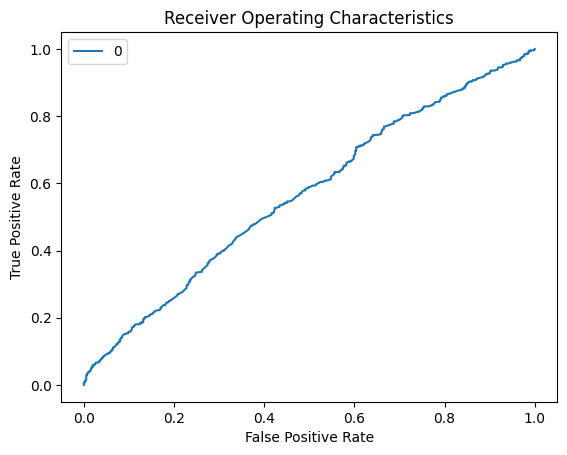

In [19]:
roc_path = os.path.abspath(roc_path)
print("ROC Image Output Filename: " + roc_path)

try:
    if metrics_output is not None:
        print ("KFP metric output was found.  Logging output metrics after calculation.")    
    else:
        print ("KFP metric output not found.")
except NameError:
    print ("KFP metric output not found.")
    metrics_output = None

evaluate_model(model, X_test, y_test, roc_path, metrics_output=metrics_output)

## Save the model

Save the model to disk for use by an inference service.

In [20]:
onnx_path = os.path.abspath(onnx_path)
print ("ONNX Model Output Filename: " + onnx_path)

save_model(model, num_features, onnx_path)

ONNX Model Output Filename: /opt/app-root/src/baseball/target/models/predict_pitch/model.onnx
